In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
train = pd.read_csv("job_change_train.csv")



In [3]:
X = train.drop(columns=["willing_to_change_job", 'id'])
y = train["willing_to_change_job"]

In [4]:
categorical_features = [
    "gender", "education", "field_of_studies", "is_studying",
    "county", "is_certified", "size_of_company", "type_of_company","years_since_job_change","years_of_experience"
]

numeric_features = [
    "age", "relative_wage", 
     "hours_of_training"
]


In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [6]:
bal_acc = make_scorer(balanced_accuracy_score)


In [7]:
knn = Pipeline([
    ("prep", preprocessor),
    ("clf", KNeighborsClassifier())
])

knn_params = {
    "clf__n_neighbors": [5, 10, 20],
    "clf__weights": ["uniform", "distance"]
}


In [8]:
log_reg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg_params = {
    "clf__C": [0.01, 0.1, 1, 10]
}


In [9]:
svm = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC())
])

svm_params = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.1]
}


In [10]:
dt = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

dt_params = {
    "clf__max_depth": [5, 10, 20, None],
    "clf__min_samples_leaf": [1, 5, 10]
}


In [11]:
rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_params = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [10, None],
    "clf__min_samples_leaf": [1, 5]
}


In [12]:
gb = Pipeline([
    ("prep", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_params = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 5]
}


In [13]:
print(X)

        gender  age   education field_of_studies is_studying      county  \
0         Male   22  higher_BSc          science          no  county_118   
1         Male   27  higher_BSc          science          no  county_028   
2         Male   38  higher_BSc          science          no  county_031   
3      Unknown   47  higher_BSc          science          no  county_080   
4         Male   28  higher_BSc          science          no  county_118   
...        ...  ...         ...              ...         ...         ...   
12422     Male   27   secondary   no_information   full_time  county_084   
12423     Male   31  higher_BSc          science          no  county_059   
12424     Male   47         Phd          science          no  county_118   
12425     Male   24  higher_BSc          science          no  county_059   
12426     Male   27  higher_BSc          science   full_time  county_028   

       relative_wage years_since_job_change years_of_experience  \
0             162.84

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [15]:
models = {
    "Logistic Regression": (log_reg, log_reg_params),
    "KNN": (knn, knn_params),
    "SVM": (svm, svm_params),
    "Decision Tree": (dt, dt_params),
    "Random Forest": (rf, rf_params),
    "Gradient Boosting": (gb, gb_params)
}

results = {}

for name, (model, params) in models.items():
    grid = GridSearchCV(
        model,
        param_grid=params,
        cv=cv,
        scoring=bal_acc,
        n_jobs=-1
    )
    grid.fit(X, y)
    results[name] = {"Best Score":grid.best_score_
    ,"Best Results": grid.best_params_}
    print(f"{name}: {grid.best_score_:.4f} with params {grid.best_params_}")


Logistic Regression: 0.6501 with params {'clf__C': 10}
KNN: 0.6826 with params {'clf__n_neighbors': 20, 'clf__weights': 'distance'}
SVM: 0.7106 with params {'clf__C': 1, 'clf__gamma': 0.1}
Decision Tree: 0.7159 with params {'clf__max_depth': 10, 'clf__min_samples_leaf': 5}
Random Forest: 0.6821 with params {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 500}
Gradient Boosting: 0.7122 with params {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 100}


In [16]:
df_results=pd.DataFrame(results).T
df_results.reset_index(inplace=True)
df_results=df_results.rename(columns={'index':"Model"})
Best_model=df_results[df_results["Best Score"]==df_results["Best Score"].max()]


0.65
0.682
0.683
0.711
0.712
0.716


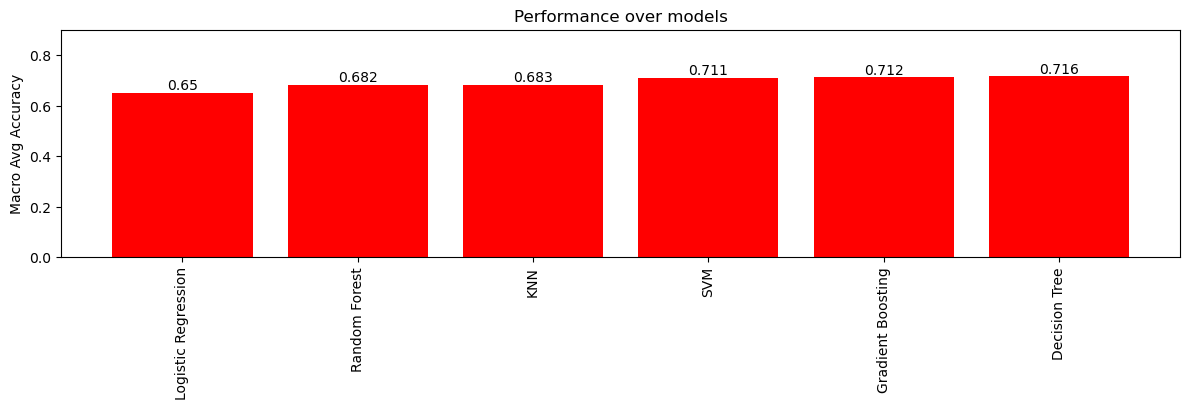

In [17]:
#printing a barpot to see compraisons between models
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,4))
df_results=df_results.sort_values("Best Score")
df_results.reset_index(inplace=True, drop=True)
bars=plt.bar(df_results['Model'], df_results['Best Score'].round(3), color='red')
plt.ylabel("Macro Avg Accuracy")
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Performance over models")
i=0
for bar in bars:
    height =  df_results.loc[i, "Best Score"].round(3)
    print(height)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height+0.001,
        df_results.loc[i, "Best Score"].round(3),
        ha='center',
        va='bottom'
    )
    i+=1
plt.ylim(0,0.9)
plt.show()

In [18]:
Best_model

,Model,Best Score,Best Results
3,Decision Tree,0.715945,"{'clf__max_depth': 10, 'clf__min_samples_leaf'..."


In [19]:
#Exporting the decision tree model to a csv_file to remember it for the test vaariablles
Best_model.to_csv("best_params.csv")